In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Data preprocessing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Regression analysis
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Natural language processing
import string
from nltk.corpus import stopwords 
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec

## Prepare the dataset

We'll use the Wine Tasting dataset [available on Kaggle](https://www.kaggle.com/mysarahmadbhat/wine-tasting)

In [4]:
# Adjust path
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wine_prices/winemag-data-130k-v2.csv')

In [5]:
df.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Preprocess and clean data

#### Replace null strings with 'None'

In [6]:
print(f'The shape is {df.shape}\n')
df.info()

The shape is (129971, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float6

In [7]:
# Drop rows where the country or variety is null
df = df.dropna(subset=['country','variety'])

In [8]:
# Replace null strings with 'None'
replace_nan = ['designation',
               'region_1',
               'region_2',
               'taster_name',
               'taster_twitter_handle']
for col in replace_nan:
    df[col] = df[col].replace(np.nan, 'None')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Replace missing prices with the mean for their country

In [9]:
# Determine the percentage of missing prices
(df['price'].isna().sum() / df['price'].shape[0]) * 100

6.921874879721647

In [10]:
# Calculate the mean price for each country
df_avg = df[['country','price']]
df_avg = df_avg.groupby(by='country').mean()
df_avg.head()

,price
country,
Argentina,24.510117
Armenia,14.500000
Australia,35.437663
Austria,30.762772
Bosnia and Herzegovina,12.500000


In [11]:
# Takes the average price from df_avg and replaces null prices in df
# The .dropna() drops the one null value remaining
df = df.set_index('country').combine_first(df_avg).reset_index().dropna()

In [12]:
df = df.set_index('id')
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
id,,,,,,,,,,,,,
16,Argentina,"Baked plum, molasses, balsamic vinegar and che...",Felix,87,30.0,Other,Cafayate,None,Michael Schachner,@wineschach,Felix Lavaque 2010 Felix Malbec (Cafayate),Malbec,Felix Lavaque
17,Argentina,Raw black-cherry aromas are direct and simple ...,Winemaker Selection,87,13.0,Mendoza Province,Mendoza,None,Michael Schachner,@wineschach,Gaucho Andino 2011 Winemaker Selection Malbec ...,Malbec,Gaucho Andino
183,Argentina,With attractive melon and other tropical aroma...,None,88,12.0,Other,Salta,None,Michael Schachner,@wineschach,Alamos 2007 Torrontés (Salta),Torrontés,Alamos
224,Argentina,Blackberry and road-tar aromas are dark and st...,Lunta,90,22.0,Mendoza Province,Luján de Cuyo,None,Michael Schachner,@wineschach,Mendel 2014 Lunta Malbec (Luján de Cuyo),Malbec,Mendel
231,Argentina,"Meaty and rubbery, but that's young Bonarda. T...",None,85,10.0,Mendoza Province,Mendoza,None,Michael Schachner,@wineschach,Andean Sky 2007 Bonarda (Mendoza),Bonarda,Andean Sky


### Feature engineering

#### Manual one-hot-encoding for new world vs. old world countries

In [13]:
# Apologies for the long, ugly lists!
# New world vs. old world classifications from Wine Folly
new_world_list = [
    'Argentina',
    'Australia',
    'Brazil',
    'Canada',
    'Chile',
    'China',
    'Egypt',
    'India',
    'Mexico',
    'New Zealand',
    'Peru',
    'South Africa',
    'US',
    'Uruguay'
]

In [14]:
# Ancient world wines are grouped in with old world wines
old_world_list = [
    'Armenia',
    'Austria',
    'Bosnia and Herzegovina',
    'Bulgaria',
    'Croatia',
    'Cyprus',
    'Czech Republic',
    'England',
    'France',
    'Georgia',
    'Germany',
    'Greece',
    'Hungary',
    'Israel',
    'Italy',
    'Lebanon',
    'Luxembourg',
    'Macedonia',
    'Moldova',
    'Morocco',
    'Portugal',
    'Romania',
    'Serbia',
    'Slovakia',
    'Slovenia',
    'Spain',
    'Switzerland',
    'Turkey',
    'Ukraine'
]    

In [15]:
# Creates boolean masks for new world and old world countries
df['new_world'] = df['country'].apply(lambda x: x in new_world_list)
df['old_world'] = df['country'].apply(lambda x: x in old_world_list)

## Exploratory data analysis

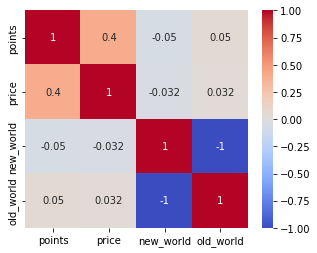

In [16]:
plt.figure(figsize = (5,4))
sns.heatmap(df.corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10});

Initial takeaways:
* Points is moderately correlated (0.4) with price
* New_world has a very small negative correlation (-0.032) with price
* Conversely, old_world has a very small positive correlation (0.032) with price

In [17]:
# Creates a smaller dataframe that groups by country
country_avg = df[['points','price','country','variety', 'new_world', 'old_world']]
country_avg = df.groupby('country').mean()
country_avg['count'] = df.groupby('country')['country'].count()
# Converts new_world and old_world to boolean for the sake of plotting
country_avg['new_world'] = country_avg['new_world'].astype('boolean')
country_avg['old_world'] = country_avg['old_world'].astype('boolean')
country_avg = country_avg.reset_index()
country_avg.head()

,country,points,price,new_world,old_world,count
0,Argentina,86.710263,24.510117,True,False,3800
1,Armenia,87.500000,14.500000,False,True,2
2,Australia,88.580507,35.437663,True,False,2329
3,Austria,90.101345,30.762772,False,True,3345
4,Bosnia and Herzegovina,86.500000,12.500000,False,True,2


In [18]:
# Creates an interactive Plotly Express plot
fig = px.scatter(country_avg, 
                 x='price', 
                 y='points',
                 size='count', 
                 hover_name='country',
                 color='new_world',
                 size_max=100)
fig.update_xaxes(range=[0, 60])
fig.update_yaxes(range=[84, 92])
fig.show()

## Initial linear regression

In [19]:
df_reg = df[['points','price','new_world', 'old_world']]

In [20]:
# Define X and y
X = df_reg[['points', 'new_world', 'old_world']]
y = df_reg['price']

In [21]:
# We'll use a 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# We'll use the RobustScaler because it is less sensitive to outliers
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))

In [23]:
# Fit the model on scaled training data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
train_score = model.score(X_train, y_train)
print('The training score is {:.2f}'.format(train_score))

The training score is 0.16


In [25]:
# Transform X_test after the train-test split to avoid data leakage
X_test = scaler.transform(X_test)

In [26]:
test_score = model.score(X_test, y_test)
print('The test score is {:.2f}'.format(test_score))

The test score is 0.18


We're able to predict about 18% of the variance in price by using only points and its new world/old world classification!

## A bit of NLP

### Preprocessing reviews

In [27]:
# Let's print a few example reviews to better understand the text data
rand_five = np.random.randint(low=0, high=len(df['description']), size=5)
for i in range(len(rand_five)):
    print(f"{df['description'][rand_five[i]]}\n")

Dusty aromas come with notes of ham and tropical fruits. This is more blah than focused. Tropical fruits, grapefruit and pickle brine comprise the flavors prior to a salty, slightly green finish.

This is produced from Cabernet Franc grown on the plateau south of Saumur. Red fruits are cut with a crisper texture, with a hint of tannins as well as attractive acidity. Drink now.

Gritty, roasted berry aromas are rubbery and hint at Band-Aids. In the mouth, this is O.K. in feel, albeit a bit jammy and thick. Short, generic berry flavors come with minty accents and some green on the finish.

This ripasso shows typical aromas of plum and prune, with earthy notes of turned soil. The palate offers ripe yet retrained raspberry and strawberry sensations, along with bitter almond and baking spice accents. It's straightforward, fresh and enjoyable.

Beautifully aromatic with dainty white peach, apricot and grapefruit notes, Ventosa's Tocai Friulano is a luscious, fruity white perfect for casual s

In [28]:
# Make reviews lowercase
df['clean'] = df['description'].str.lower()

In [29]:
# Remove punctuation
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

df['clean'] = df['clean'].apply(remove_punctuation)

In [30]:
df['clean'][0]

'aromas include tropical fruit broom brimstone and dried herb the palate isnt overly expressive offering unripened apple citrus and dried sage alongside brisk acidity'

In [31]:
# Installs essential NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
# Tokenize reviews and remove stopwords
# Stopwords are words that are so common that they are meaningless in topic analysis
stop_words = set(stopwords.words('english')) 

def remove_stopwords (text):
    tokenized = word_tokenize(text)
    without_stopwords = [word for word in tokenized if not word in stop_words]
    return without_stopwords

# df['clean'] = df['clean'].apply(remove_stopwords)

In [33]:
df['clean'][0]

'aromas include tropical fruit broom brimstone and dried herb the palate isnt overly expressive offering unripened apple citrus and dried sage alongside brisk acidity'

In [34]:
# Overwrites X and y from the linear regression
# For now, our only feature is the description
X = df['clean']
y = df['price']

Topic analysis with Latent Dirichlet Allocation (LDA)

In [35]:
# Vectorizer uses the custom remove_stopwords function from earlier
vectorizer = CountVectorizer(tokenizer=remove_stopwords)
X = vectorizer.fit_transform(X)

In [36]:
# Instantiates and fits an LDA model with 20 components
lda_model = LatentDirichletAllocation(n_components=20).fit(X)

In [37]:
# Prints topics
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])

In [38]:
print_topics(lda_model, vectorizer)

Topic 0:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



[('wine', 3225.6401553046167), ('flavors', 2837.1880444893372), ('like', 2582.641675653997), ('sweet', 1869.2343102222953), ('rich', 1856.7642726507443), ('color', 1653.67367005929), ('ripe', 1619.543218443909), ('tastes', 1554.9640438381102), ('texture', 1391.9449344377122), ('almost', 1383.7258109620602)]
Topic 1:
[('wine', 2438.860476823111), ('pair', 1867.8269606656384), ('would', 1193.5023234780354), ('bright', 1183.5849021268687), ('blend', 1124.1394468202843), ('fruit', 1032.4723747389648), ('aromas', 963.3851296119512), ('expression', 868.4805600759822), ('almond', 819.6840746183002), ('tones', 819.2722731962856)]
Topic 2:
[('flavors', 12291.766423777208), ('aromas', 10623.743595791066), ('finish', 10387.767795909356), ('palate', 6547.367193960458), ('berry', 6463.631947495259), ('plum', 5523.083506122649), ('herbal', 3963.164855593021), ('feels', 3319.3619361607953), ('notes', 3089.0529747738365), ('oak', 2980.8088564843024)]
Topic 3:
[('oak', 2673.6054284761626), ('wine', 266

In [39]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(60, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

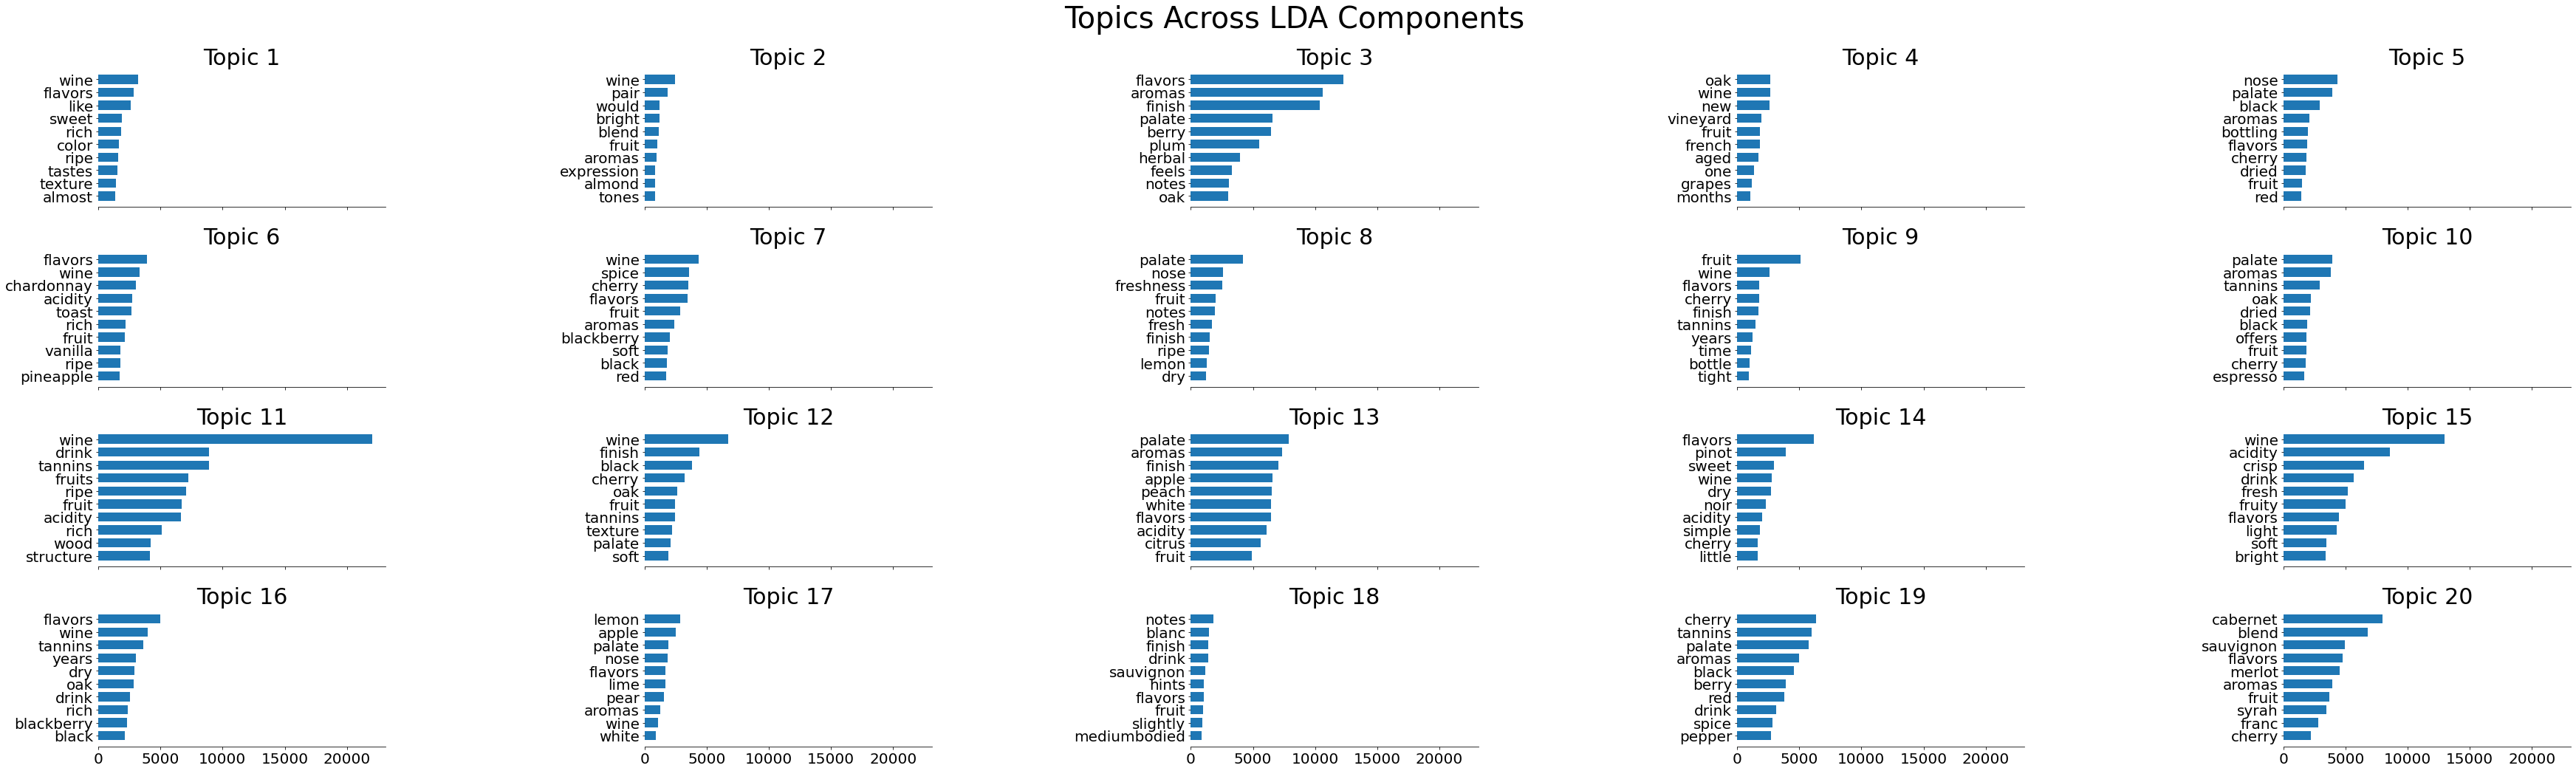

In [43]:
n_components = 20
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, feature_names, n_top_words, "Topics Across LDA Components")